### Importing Libraries

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, models
import numpy as np
from PIL import Image
from torchvision.models import ResNet18_Weights
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt


### Loading dataset 

In [11]:
def convert_to_rgb(image):
    if isinstance(image, Image.Image):     # Convert image to NumPy array if it's a PIL Image
        image = np.array(image)
    # If image is not RGB, convert it to RGB
    if len(image.shape) == 3 and image.shape[0] == 1:  # Grayscale image
        image = np.repeat(image, 3, axis=0)  # Convert to 3-channel grayscale
    elif len(image.shape) == 2:  # Single-channel grayscale image
        image = np.repeat(image[:, :, np.newaxis], 3, axis=2)  # Convert to 3-channel grayscale
    return image


transform = transforms.Compose([ # Define the transformation pipeline to augment data
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.07, hue=0.07),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.Lambda(convert_to_rgb),  # Apply convert_to_rgb function
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Convert images to tensors
])

caltech_dataset = torchvision.datasets.Caltech101(root='./data', download=True, transform=transform)

train_size = int(0.8 * len(caltech_dataset)) # giving 80 percent of data to the train set 
val_size = len(caltech_dataset) - train_size #giving 20 percent of data to the test set
train_dataset, val_dataset = torch.utils.data.random_split(caltech_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True) #creating loaders
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified


### Ploting some augmented data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


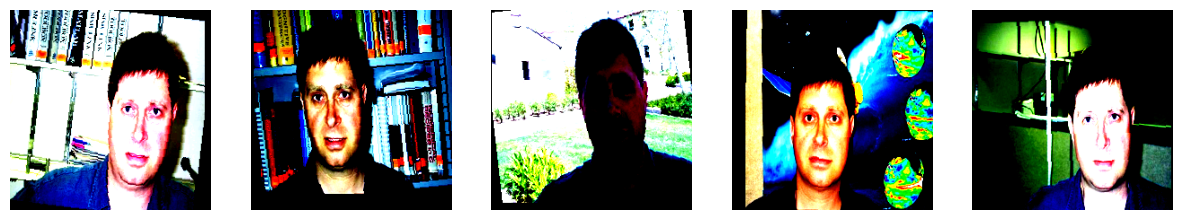

In [12]:
num_samples = 5
sample_indices = [i for i in range(num_samples)]

fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

for i, idx in enumerate(sample_indices):
    image, _ = caltech_dataset[idx]  # Get augmented image and label
    image = image.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C) for visualization
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

### Creating plain CNN

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 101)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 128 * 28 * 28)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Creating frozen Resnet as Feature Extractor

In [14]:
class ResNetFeatureExtractor(nn.Module):
    def __init__(self, num_classes):
        super(ResNetFeatureExtractor, self).__init__()
        resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        for param in resnet.parameters(): # freezing the weights of the ResNet layers
            param.requires_grad = False
        self.features = nn.Sequential(*list(resnet.children())[:-1])  # extracting features from ResNet's final layer before the classification layer
        self.classifier = nn.Linear(resnet.fc.in_features, num_classes)  # adding custom classification layer

    def forward(self, x):
        x = self.features(x) # Extract features
        x = torch.flatten(x, 1) # Flatten features
        x = self.classifier(x) # Pass features through the custom classifier
        return x

### Creating pretrained model with Resnet 18 as Fine Tuned

In [15]:
class FineTunedResNet(nn.Module):
    def __init__(self, num_classes):
        super(FineTunedResNet, self).__init__() # Load pre-trained ResNet-18 model
        self.model_ft = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)  # Replace the final fully connected layer with a new one
        self.model_ft.fc = nn.Linear(self.model_ft.fc.in_features, num_classes)

    def forward(self, x):
        return self.model_ft(x)


### Saving model as binaries

In [16]:
plane_cnn_model = CNN()
frozen_resnet_model = ResNetFeatureExtractor(101)
fine_tuned_resnet = FineTunedResNet(101)

torch.save(plane_cnn_model, './models/plain_cnn.pth')
torch.save(frozen_resnet_model, './models/feature_extractor.pth')
torch.save(fine_tuned_resnet, './models/fine_tuned.pth')

### Testing models and ploting results

In [18]:
def eval_model(model, test_loader):
    model.eval()
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    return all_targets, all_predictions

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=4, patience=3):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    early_stopping_counter = 0
    best_model_state_dict = None

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        # Compute average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

        # Compute average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss, val_loss))

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state_dict = model.state_dict()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print("Early stopping after {} epochs of no improvement.".format(patience))
                break

    # Load the best model state_dict
    if best_model_state_dict is not None:
        model.load_state_dict(best_model_state_dict)

    return model, train_losses, val_losses

plane_cnn_model = torch.load("./models/plain_cnn.pth")
frozen_resnet_model = torch.load("./models/feature_extractor.pth")
fine_tuned_resnet_model = torch.load("./models/fine_tuned.pth")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move models to device
plane_cnn_model.to(device)
frozen_resnet_model.to(device)
fine_tuned_resnet_model.to(device)

# Train each model
models = [fine_tuned_resnet_model, plane_cnn_model, frozen_resnet_model]
trained_models = []
for model in models:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    trained_model, train_losses, val_losses = train_model(model, train_loader, test_loader, criterion, optimizer)
    trained_models.append(trained_model)


Epoch [1/4], Train Loss: 1.9589, Val Loss: 1.3691
Epoch [2/4], Train Loss: 0.9568, Val Loss: 1.1614
Epoch [3/4], Train Loss: 0.6866, Val Loss: 0.8503
Epoch [4/4], Train Loss: 0.4891, Val Loss: 0.8515
Epoch [1/4], Train Loss: 6.7159, Val Loss: 3.6600
Epoch [2/4], Train Loss: 3.5829, Val Loss: 3.4461
Epoch [3/4], Train Loss: 3.4472, Val Loss: 3.2856
Epoch [4/4], Train Loss: 3.3425, Val Loss: 3.2360
Epoch [1/4], Train Loss: 2.2237, Val Loss: 1.0544
Epoch [2/4], Train Loss: 0.8271, Val Loss: 0.6285
Epoch [3/4], Train Loss: 0.5601, Val Loss: 0.5292
Epoch [4/4], Train Loss: 0.4268, Val Loss: 0.4691


### Ploting results

Classification Report for Model 1
              precision    recall  f1-score   support

           0       0.99      0.96      0.97        95
           1       0.99      0.97      0.98        93
           2       0.92      0.79      0.85        43
           3       0.99      0.98      0.99       165
           4       1.00      0.44      0.62         9
           5       1.00      0.80      0.89       155
           6       0.00      0.00      0.00         8
           7       0.60      0.50      0.55         6
           8       0.30      0.75      0.43        12
           9       0.88      0.50      0.64        14
          10       0.25      0.29      0.27         7
          11       0.40      0.80      0.53         5
          12       0.65      0.96      0.77        25
          13       0.57      1.00      0.72        25
          14       1.00      0.67      0.80         9
          15       0.80      0.89      0.84        18
          16       1.00      0.80      0.89    

c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

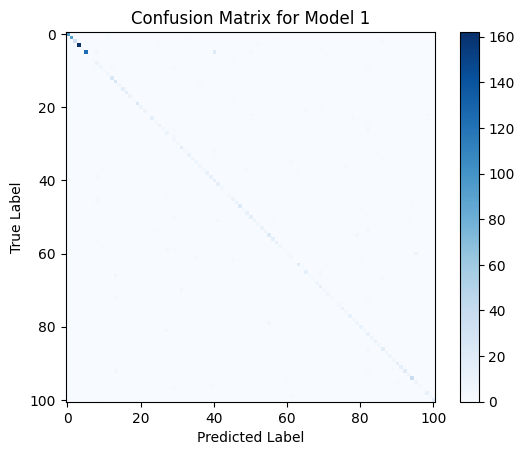

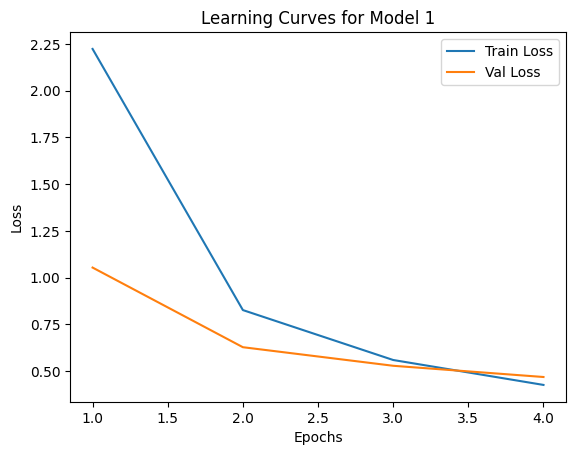

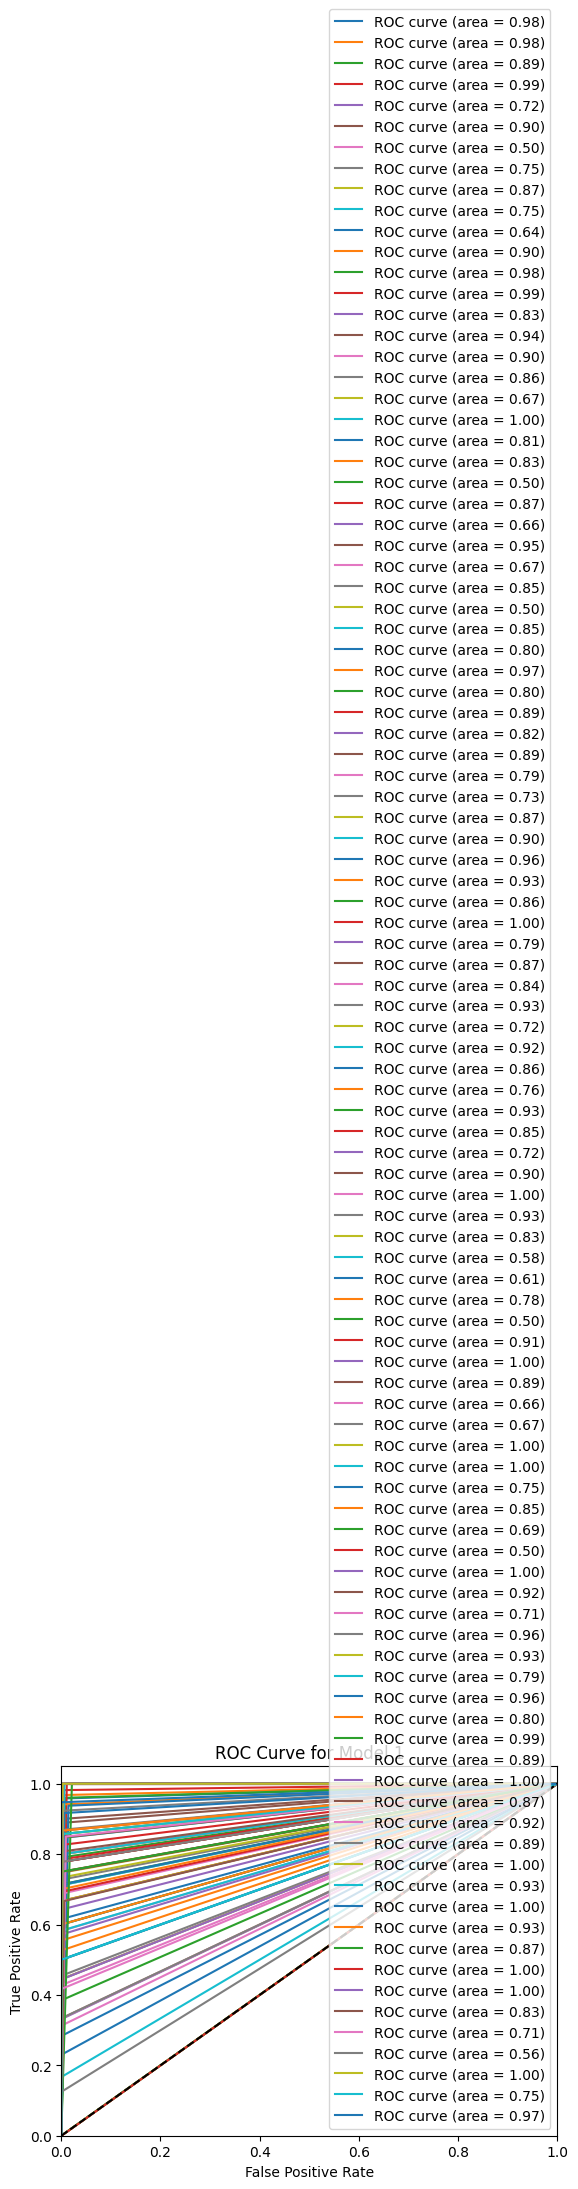

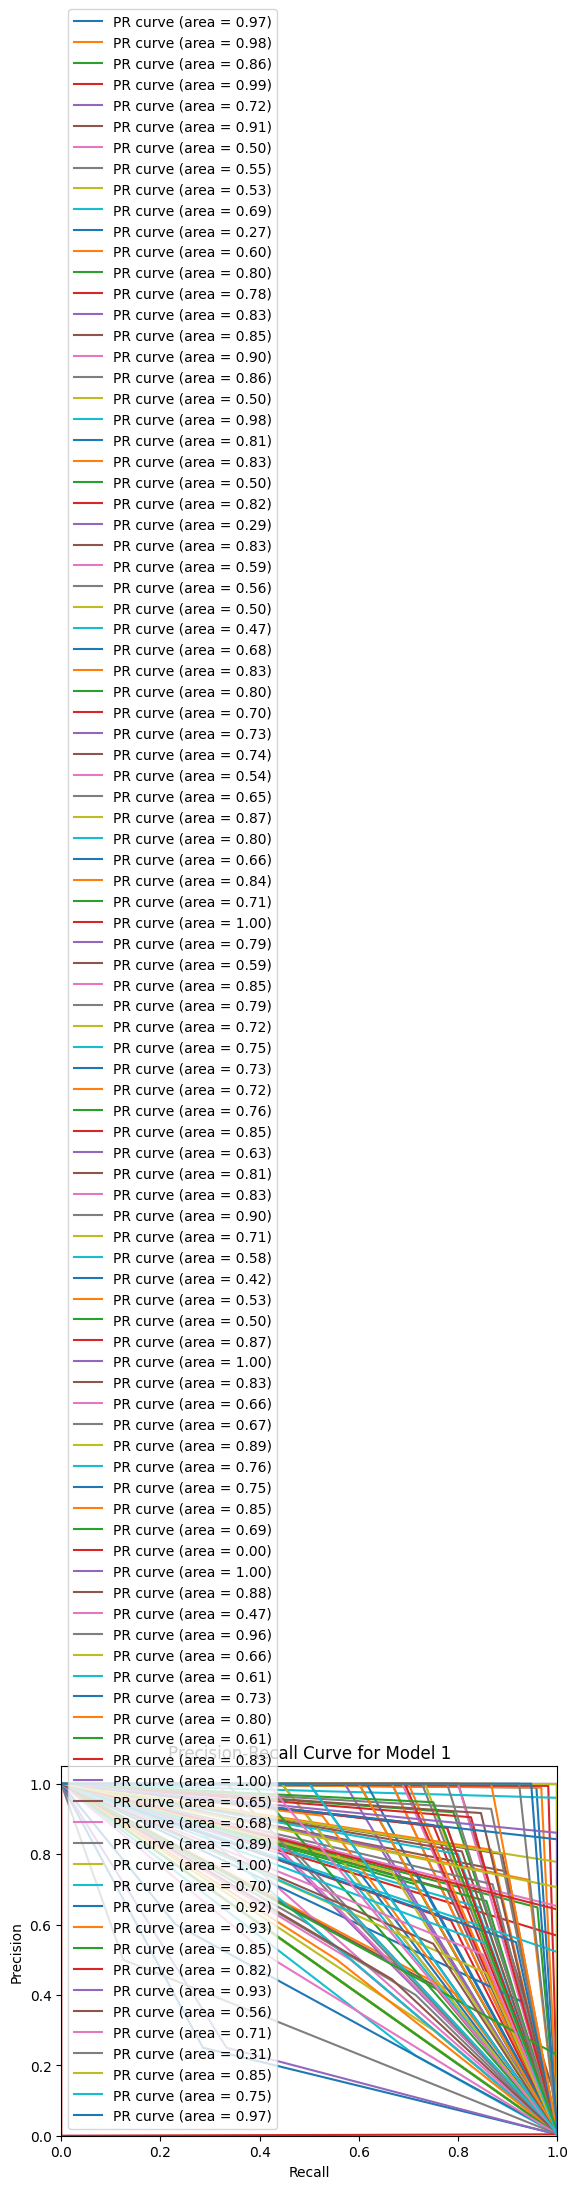

Top-1 Error Rate for Model 1: 21.95%
Classification Report for Model 2
              precision    recall  f1-score   support

           0       0.33      0.88      0.48        95
           1       0.90      0.74      0.81        93
           2       0.18      0.91      0.30        43
           3       0.46      0.95      0.62       165
           4       0.00      0.00      0.00         9
           5       0.35      0.92      0.50       155
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00        12
           9       0.00      0.00      0.00        14
          10       0.00      0.00      0.00         7
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00        25
          13       0.00      0.00      0.00        25
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00        18
          

c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

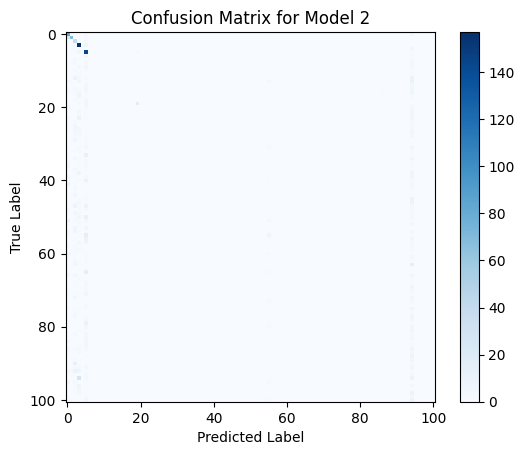

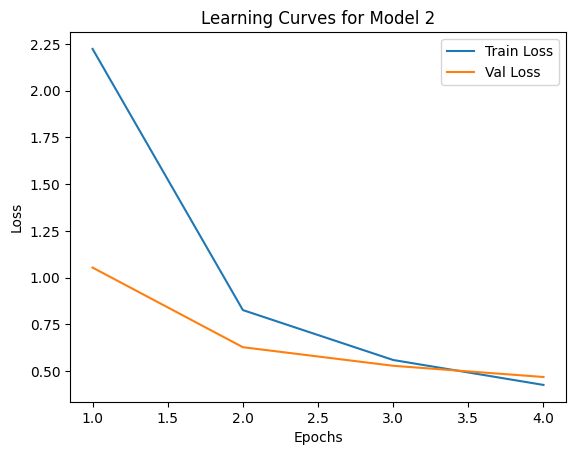

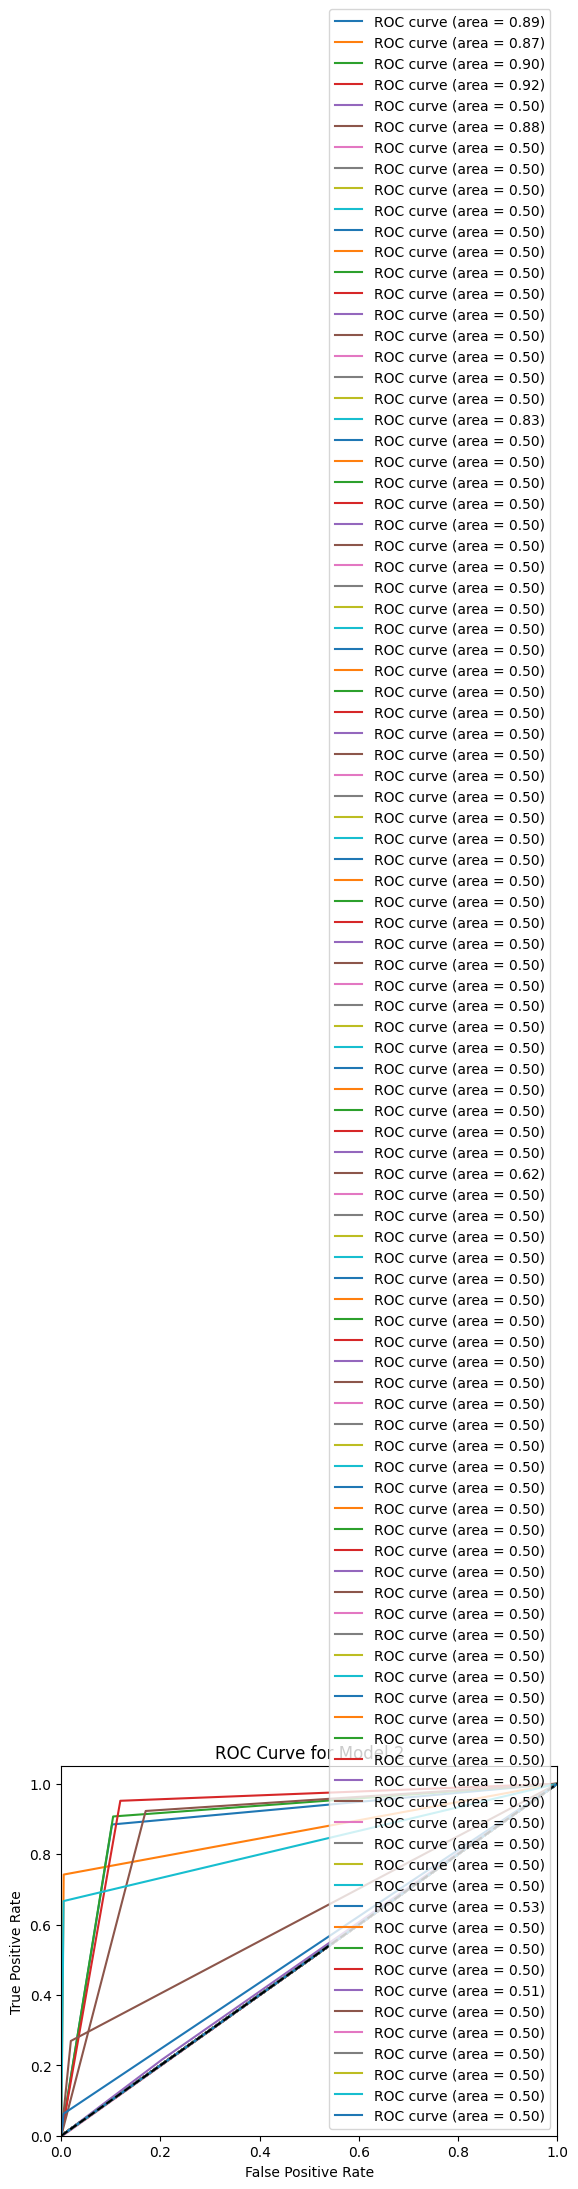

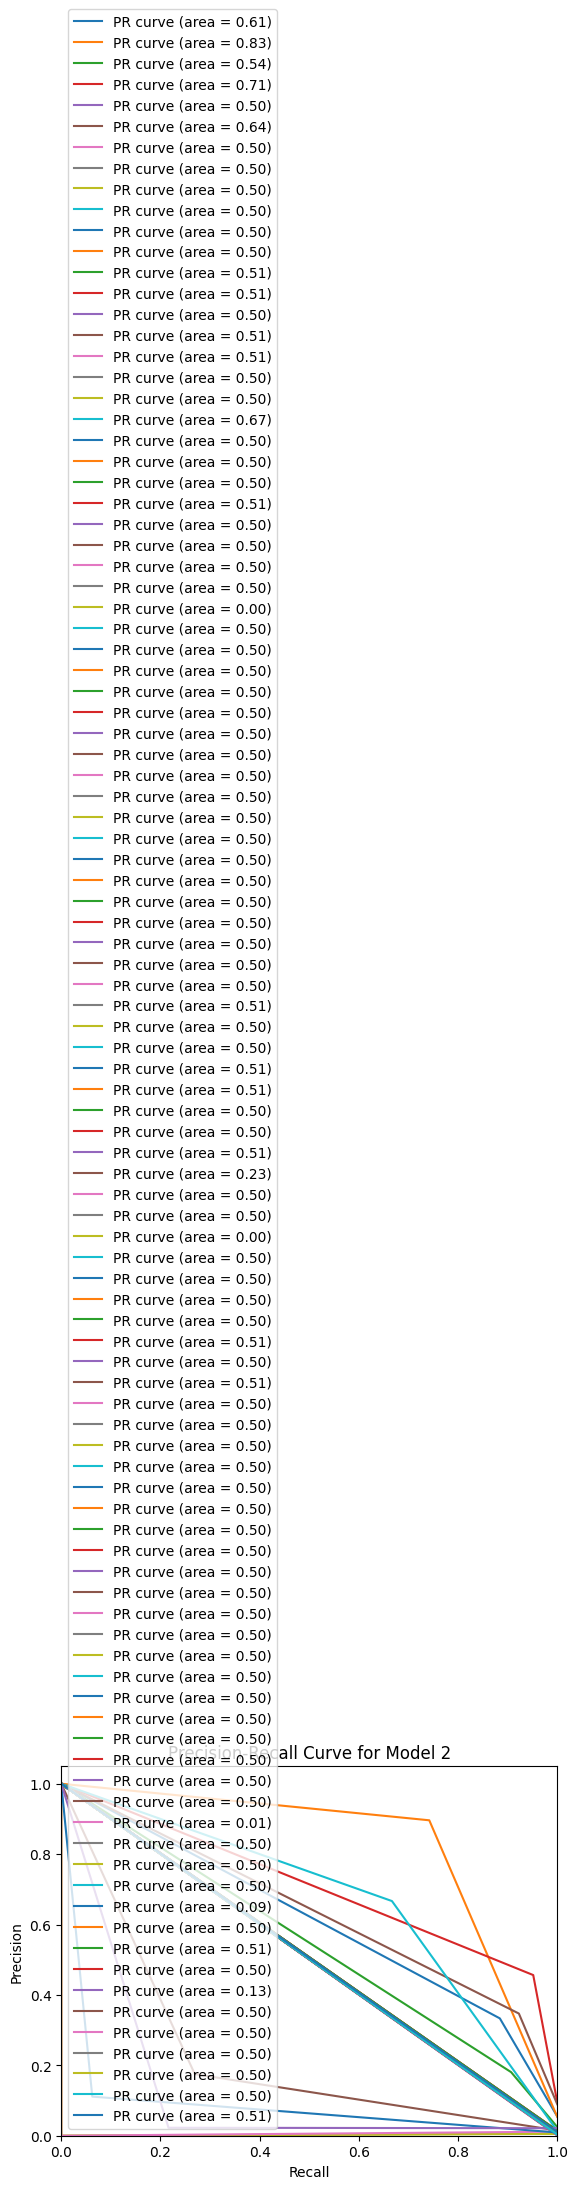

Top-1 Error Rate for Model 2: 69.82%
Classification Report for Model 3
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        95
           1       0.95      0.98      0.96        93
           2       0.95      0.98      0.97        43
           3       0.96      1.00      0.98       165
           4       1.00      1.00      1.00         9
           5       0.97      0.98      0.98       155
           6       1.00      0.38      0.55         8
           7       0.75      0.50      0.60         6
           8       1.00      0.83      0.91        12
           9       0.90      0.64      0.75        14
          10       0.57      0.57      0.57         7
          11       1.00      1.00      1.00         5
          12       0.96      0.96      0.96        25
          13       0.93      1.00      0.96        25
          14       0.80      0.44      0.57         9
          15       0.94      0.94      0.94        18
          

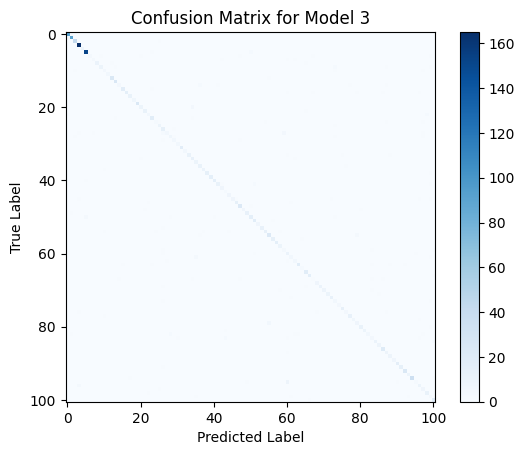

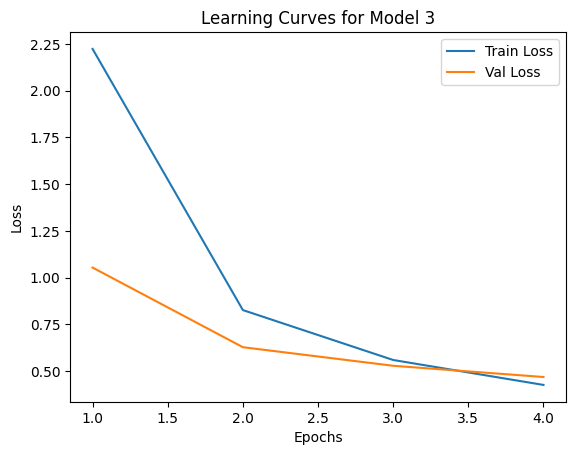

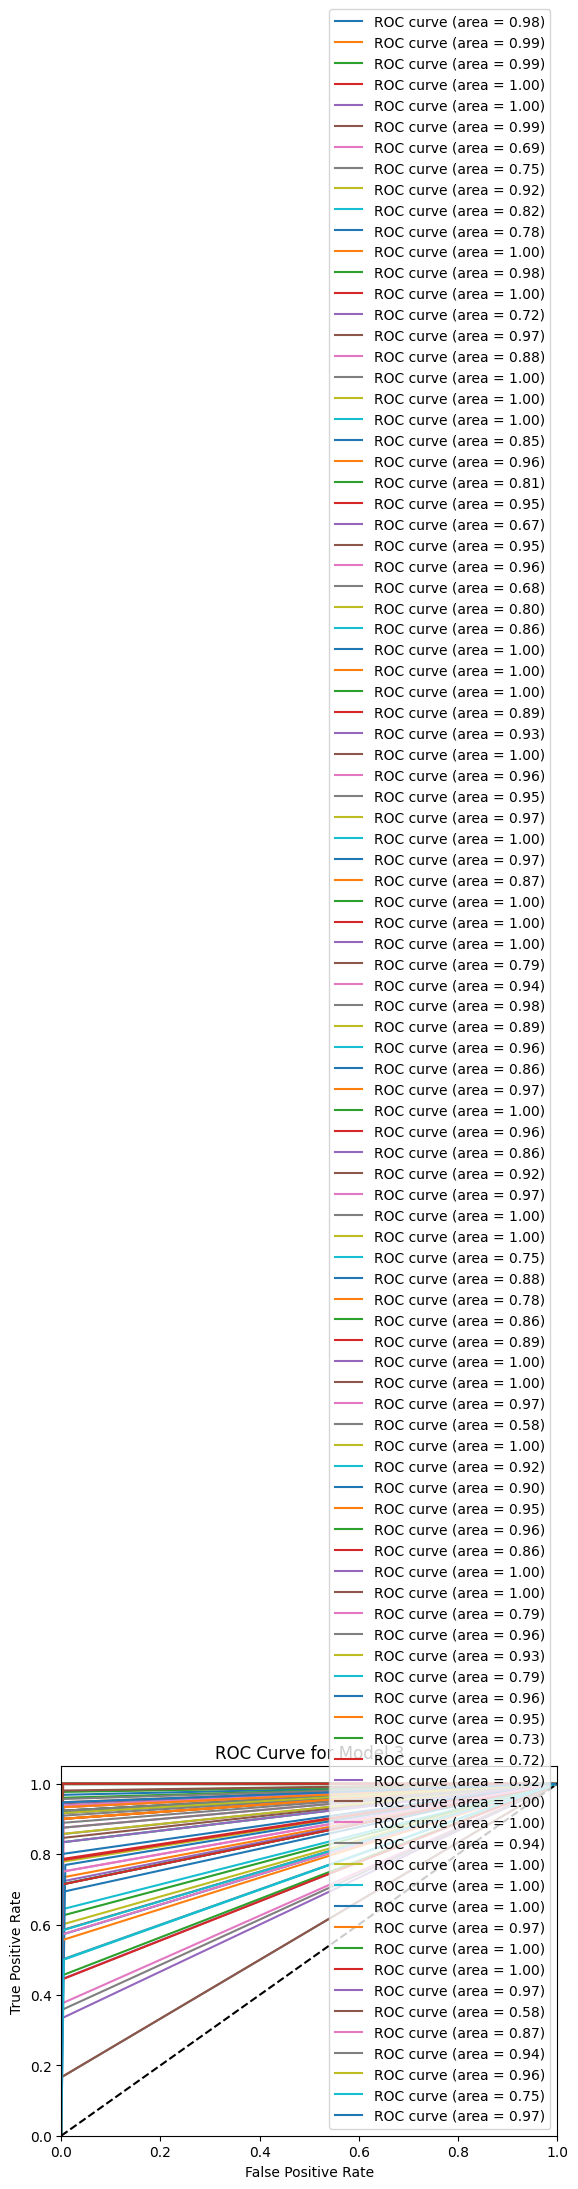

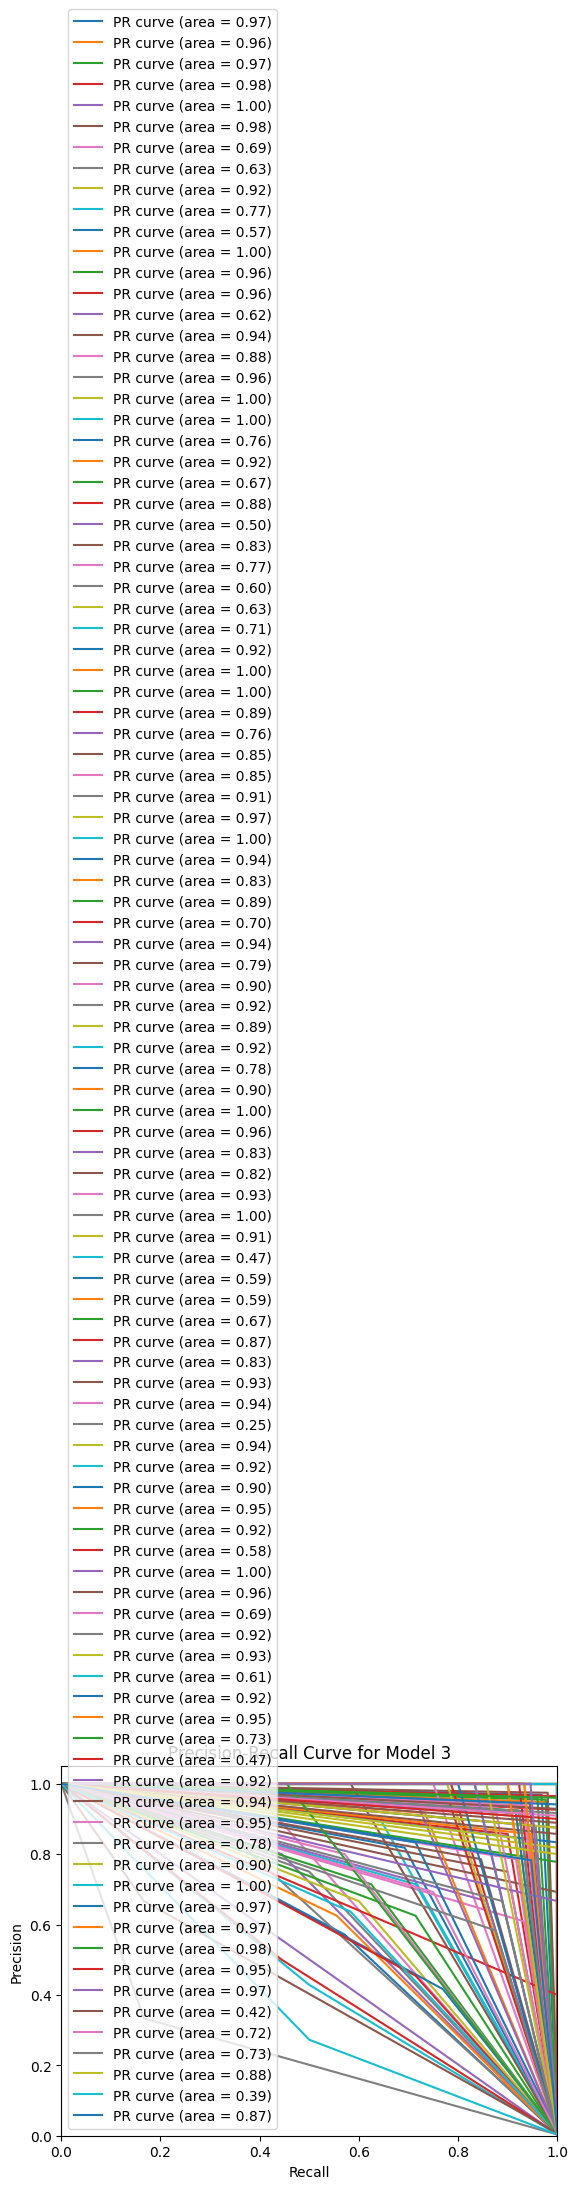

Top-1 Error Rate for Model 3: 11.00%


In [23]:
from sklearn.preprocessing import label_binarize

num_classes = 101
# Evaluation and reporting
for i, model in enumerate(trained_models):
    # Evaluation
    targets, predictions = eval_model(model, test_loader)
    
    # Classification report
    print("Classification Report for Model {}".format(i+1))
    print(classification_report(targets, predictions))
    
    # Confusion matrix
    conf_matrix = confusion_matrix(targets, predictions)
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix for Model {}'.format(i+1))
    plt.show()

    # Learning curves
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curves for Model {}'.format(i+1))
    plt.legend()
    plt.show()

    # ROC curve
    targets_one_hot = label_binarize(targets, classes=list(range(num_classes)))
    predictions_one_hot = label_binarize(predictions, classes=list(range(num_classes)))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for j in range(num_classes):
        fpr[j], tpr[j], _ = roc_curve(targets_one_hot[:, j], predictions_one_hot[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])
        plt.plot(fpr[j], tpr[j], label='ROC curve (area = %0.2f)' % roc_auc[j])

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Model {}'.format(i+1))
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall curve
    precision = dict()
    recall = dict()
    pr_auc = dict()
    for j in range(num_classes):
        precision[j], recall[j], _ = precision_recall_curve(targets_one_hot[:, j], predictions_one_hot[:, j])
        pr_auc[j] = auc(recall[j], precision[j])
        plt.plot(recall[j], precision[j], label='PR curve (area = %0.2f)' % pr_auc[j])

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve for Model {}'.format(i+1))
    plt.legend(loc="lower left")
    plt.show()

    # Top-1 error rate in %
    top1_error_rate = (1 - sum([1 if pred == target else 0 for pred, target in zip(predictions, targets)]) / len(targets)) * 100
    print("Top-1 Error Rate for Model {}: {:.2f}%".format(i+1, top1_error_rate))

### Visualizing CONV filters

Visualizing filters for Model 1


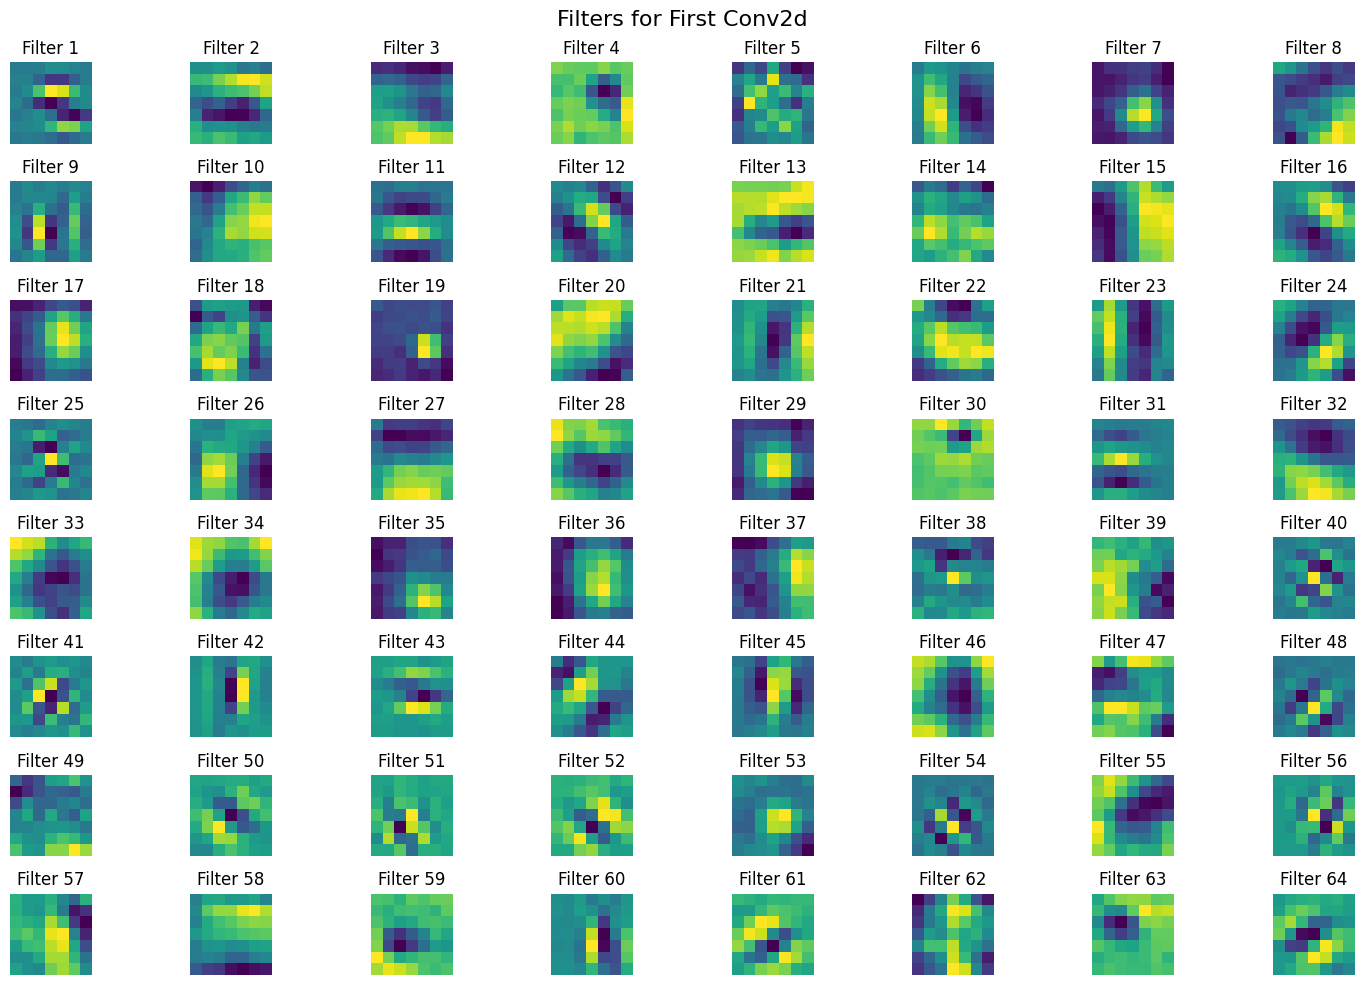

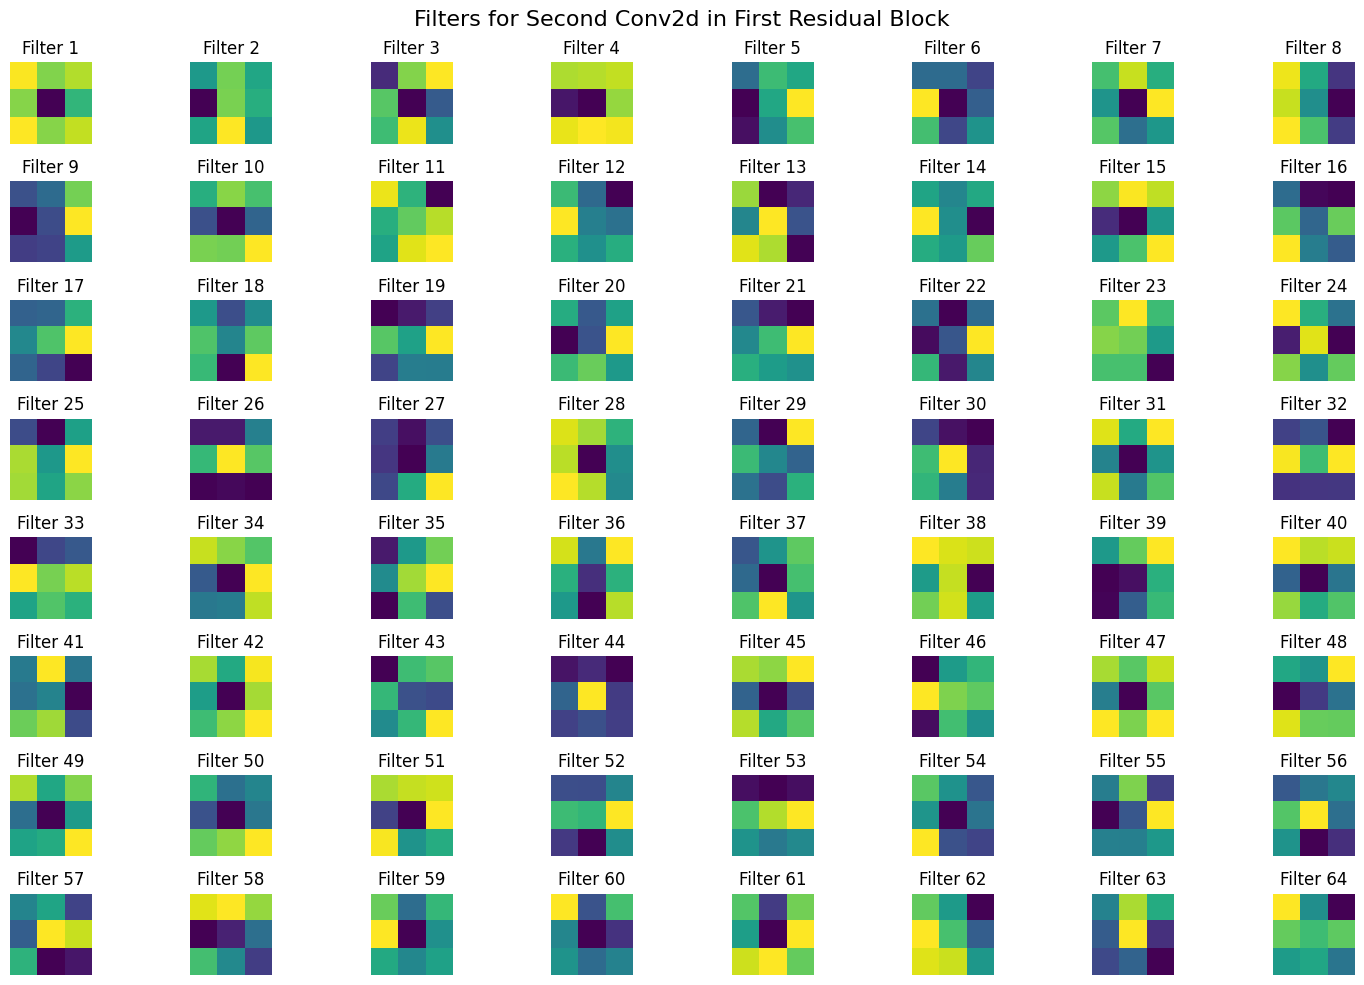

Visualizing filters for Model 2


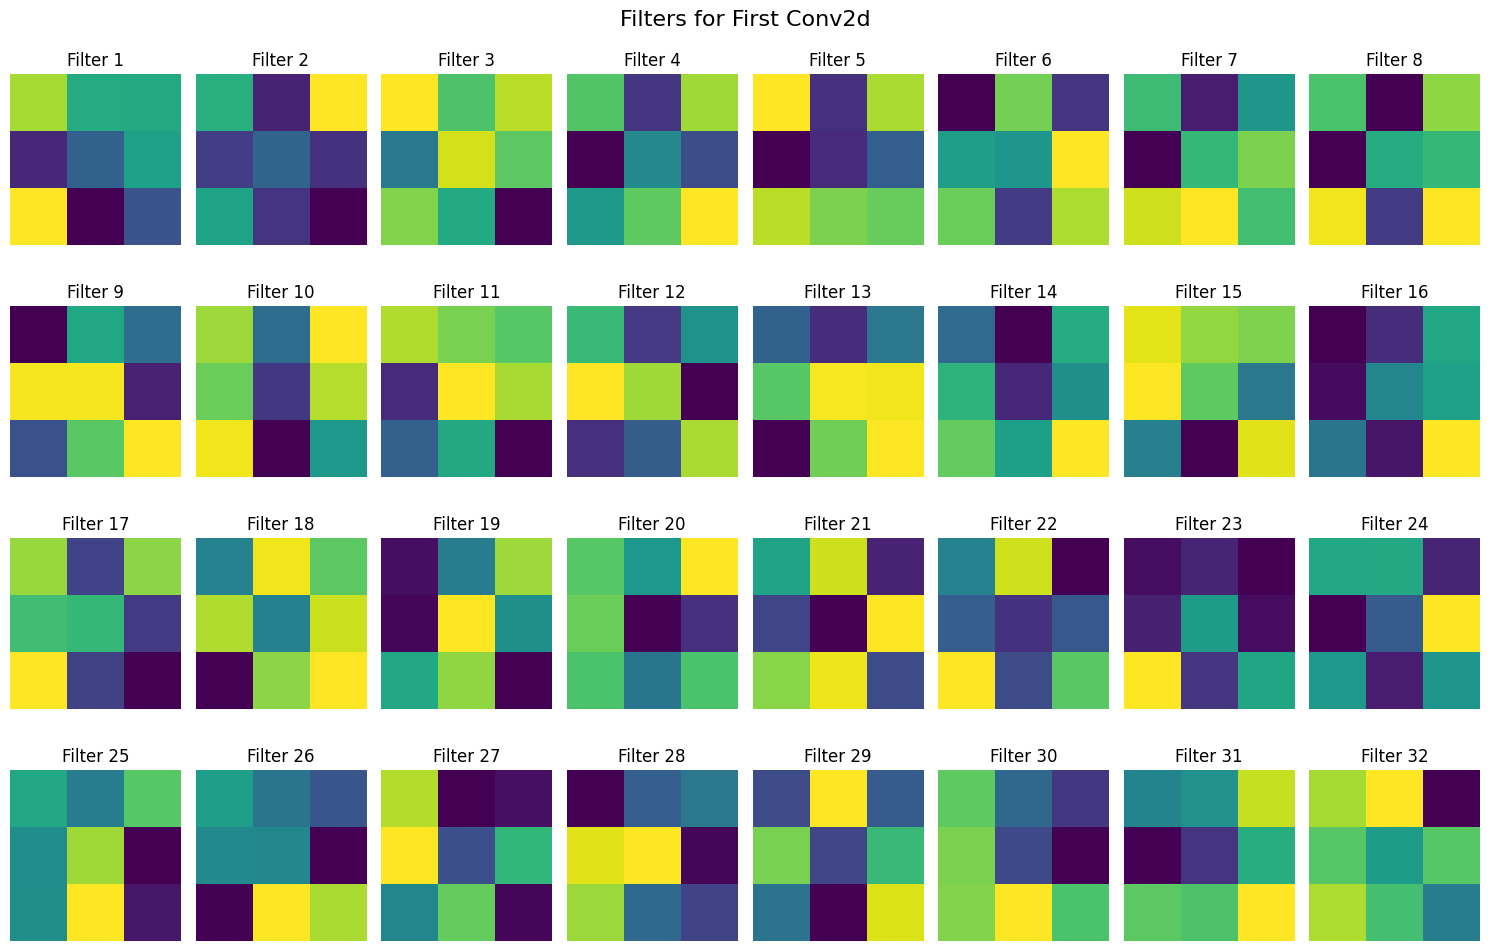

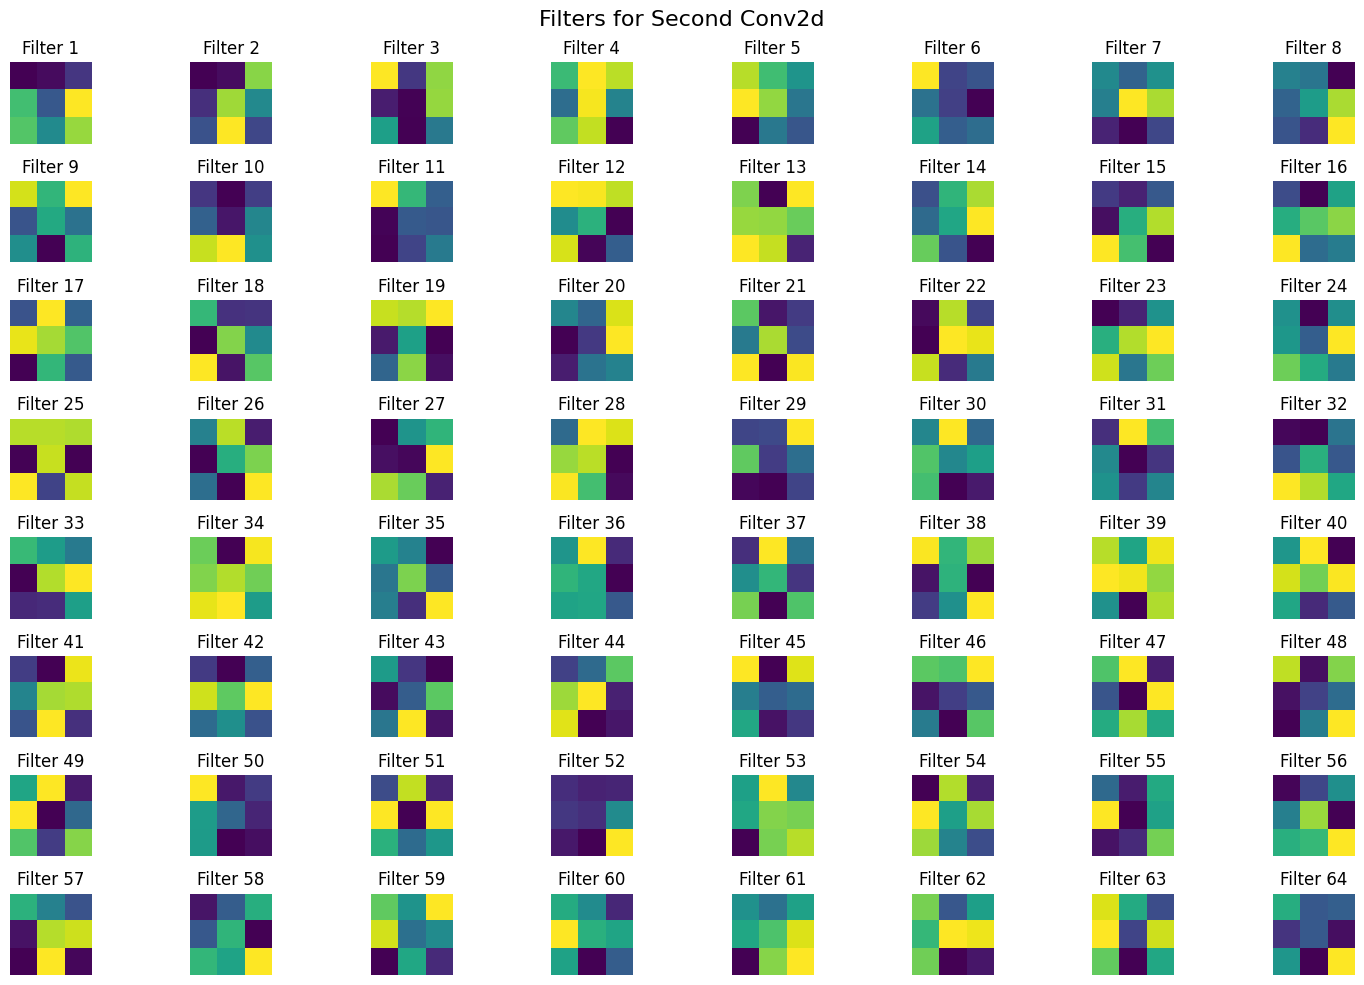

Visualizing filters for Model 3


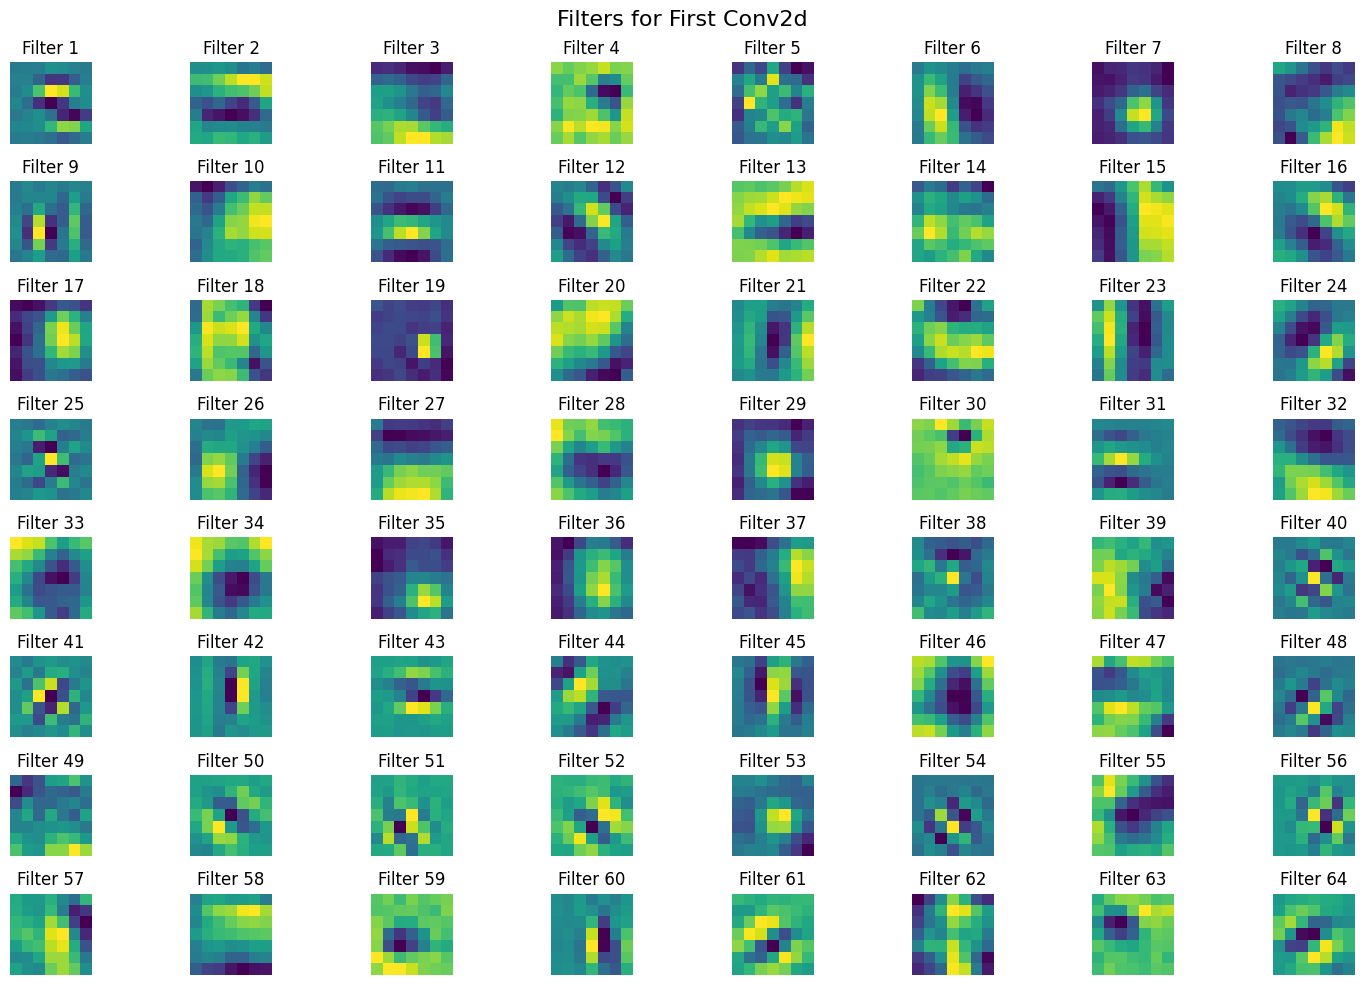

In [46]:
def plot_filters(weights, layer_name):
    num_filters = weights.shape[0]
    num_cols = 8  # Number of columns for displaying filters
    num_rows = num_filters // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
    fig.suptitle(f'Filters for {layer_name}', fontsize=16)

    for i, ax in enumerate(axes.flatten()):
        if i < num_filters:
            if weights.ndim > 1 : 
                ax.imshow(weights[i, 0], cmap='viridis')
                ax.axis('off')
                ax.set_title(f'Filter {i+1}')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

    
# Iterate over trained models
for i, model in enumerate(trained_models):
    print(f"Visualizing filters for Model {i+1}")
    if isinstance(model, FineTunedResNet):
        # Access the weights of the first convolutional layer
        first_conv_weights = model.model_ft.conv1.weight.data.cpu().numpy()
        # Access the weights of the second convolutional layer in the first residual block
        second_conv_weights = model.model_ft.layer1[0].conv1.weight.data.cpu().numpy()
        
        # Plot filters for the first Conv2d layer
        plot_filters(first_conv_weights, 'First Conv2d')
        # Plot filters for the second Conv2d layer in the first residual block
        plot_filters(second_conv_weights, 'Second Conv2d in First Residual Block')
    elif isinstance(model, ResNetFeatureExtractor):
        # Access the weights of the first convolutional layer in the features module
        first_conv_weights = model.features[0].weight.data.cpu().numpy()
        
        # Plot filters for the first Conv2d layer
        plot_filters(first_conv_weights, 'First Conv2d')
    elif isinstance(model, CNN):
         first_conv_weights = model.conv1.weight.data.cpu().numpy()
         second_conv_weights = model.conv2.weight.data.cpu().numpy()

         # Plot filters for the first Conv2d layer
         plot_filters(first_conv_weights, 'First Conv2d')

         # Plot filters for the second Conv2d layer
         plot_filters(second_conv_weights, 'Second Conv2d')


### Conclusions

* У загальних висновках до лабораторної роботи можна сказати, що тренування моделей дуже сильно залежить від аугментації та нормалізації даних. Сумарно, у ході виконання даного домашнього завдання витратив близько 6 годин на тести нейромереж із різними тестовими та валідаційними даними. І кожного разу, в залежності від виду аугментації даних - дуже сильно вапіювався кінцевий результат точності однієї з моделей. На продемонстрованих зразках, найкращим чином працюють саме pretrained Fine Tuned Resnet, та frozen Feature Extractor Resnet, однак сильно програє plane CNN model. Однак при інших значеннях JitterFilter у TransformPipe, дані кардинально відрізнялись. CNN видавала більш збалансовані результати, однак retrained Fine Tuned Resnet повертав точність від 0.81% - 1.54% в залежності від епохи (кожна епоха проходила близько 15 хвилин).

* Варто зазначити, що дані представлені у датасеті Caltech101, з якими і працювали в ході даної Лабораторної роботи є надзвичайно неоднорідними. Деякі зображення, до прикладу, містять лише один колірний канал, через що приводив їх до rgb штучно. Також, кожен з 101-го класу містить різну кількість зображень як таких. Через це, моделі, а особливо нетренована, plane cnn, не може отримати якісного навчання.

* За отриманими фільтрами з першого та другого ковуляційних шарів з Plane CNN важко зробити висновки, адже отримані Kernel мають дуже великий розмір, через що  розмір Feature map є малим, а отже складно зрозуміти, що саме відображено на даних фільтрах
* У випадку з отриманими фільтрами з Resnet feature extractor та Resnet fine tuned - розмір Kernel вже є значно меншим, а отже Feаture map є більшим, також, проглядаються деякі форми та певні патерни, однак без зображення, що подалось для опрацювання - такі висновки все ще неможливо зробити, адже розмір Kernel все ще є надто малим.
*  В ході тренування та отримання фільтраційних результатів, було помічено, що присутній blind filter, у resnet feature extractor. Це могло статись через заморозку ваг зокрема. Одним з шляхів до вирішення цієї проблеми, була б розморозка деяких ваг (при цьому залишивши деякі все ще замороженими). Також, можна було б спробувати змінити такий параметр як batch size, або ж аугментацію даних.
* За замовчуванням моделі беруть до уваги задній фон зображень, та опрацьовують його для побудови feature map. Однак зображення представлені у даному датасеті є надзвичайно різними, що вимагає більшої кількості обчислювальних потужностей та більшого часу тренування. 
* Раніше у висновку вже згадав, що представлені у датасеті зображення не всі є rgb, однак для отримання більшої кількості даних для навчання зробив функцію, що додає канали, для опрацювання даних саме у rgb форматі.

* У ході тренування майже вдалось досягти заданих у завданні результатів точності, зокрема модель feature extractor resnet демонструє середню точність в 89% та найбільшу похибку (top 1 error rate) у 11%. В свою чергу fine tuned демонструє результати у 78% середня похибка та майже 22% top 1 error rate. При більшій кількості епох, можна було б досягти і поставлених у завданні параметрів, однак це є дуже часозатратним (3 моделі на 4 епохах навчались та валідувались сумарно 115 хвилин) Також, варто зазначити що розроблена plane cnn, за даними з графіків скоріш за все underfit, адже при перегляді classification report можна побачити що багато класів просто ігноруються (precision, recall, f1-score = 0). Скоріш за все це через недостатню кількість конвуляційних шарів, або ж через неоднорідність даних (зображень деяких класів значно більше ніж зображень інших)